In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%matplotlib notebook

In [3]:
# URL For data
this_year_url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yieldYear&year=2019'
all_data_url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yieldAll'

In [4]:
# Hitting website
data = requests.get(all_data_url)

ConnectionError: HTTPSConnectionPool(host='www.treasury.gov', port=443): Max retries exceeded with url: /resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yieldAll (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fe9bc49d128>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [ ]:
# Finding the table
soup = BeautifulSoup(data.text)
table = soup.find('table', {'class': 't-chart'})

In [ ]:
# Getting headers and rows
all_my_data = []
rows = table.find_all('tr')
headers = ['_'.join(x.text.split()) for x in rows[0].find_all('th')]
data_rows = rows[1:len(rows)]
for row in data_rows:
    new_row = [x.text.strip() for x in row.find_all('td')]
    all_my_data.append(new_row)

In [ ]:
# Creating dataframe
yield_curve_df = pd.DataFrame(all_my_data, columns=headers)
yield_curve_df.describe()

In [ ]:
# Cleaning out NaN, fixing data types
yield_curve_df = yield_curve_df.replace('N/A', np.nan)
yield_curve_df['Date'] = pd.to_datetime(yield_curve_df['Date'])
yield_curve_df = yield_curve_df.set_index('Date')
yield_curve_df = yield_curve_df.apply(pd.to_numeric, errors='coerce')
yield_curve_df.describe()

<IPython.core.display.Javascript object>


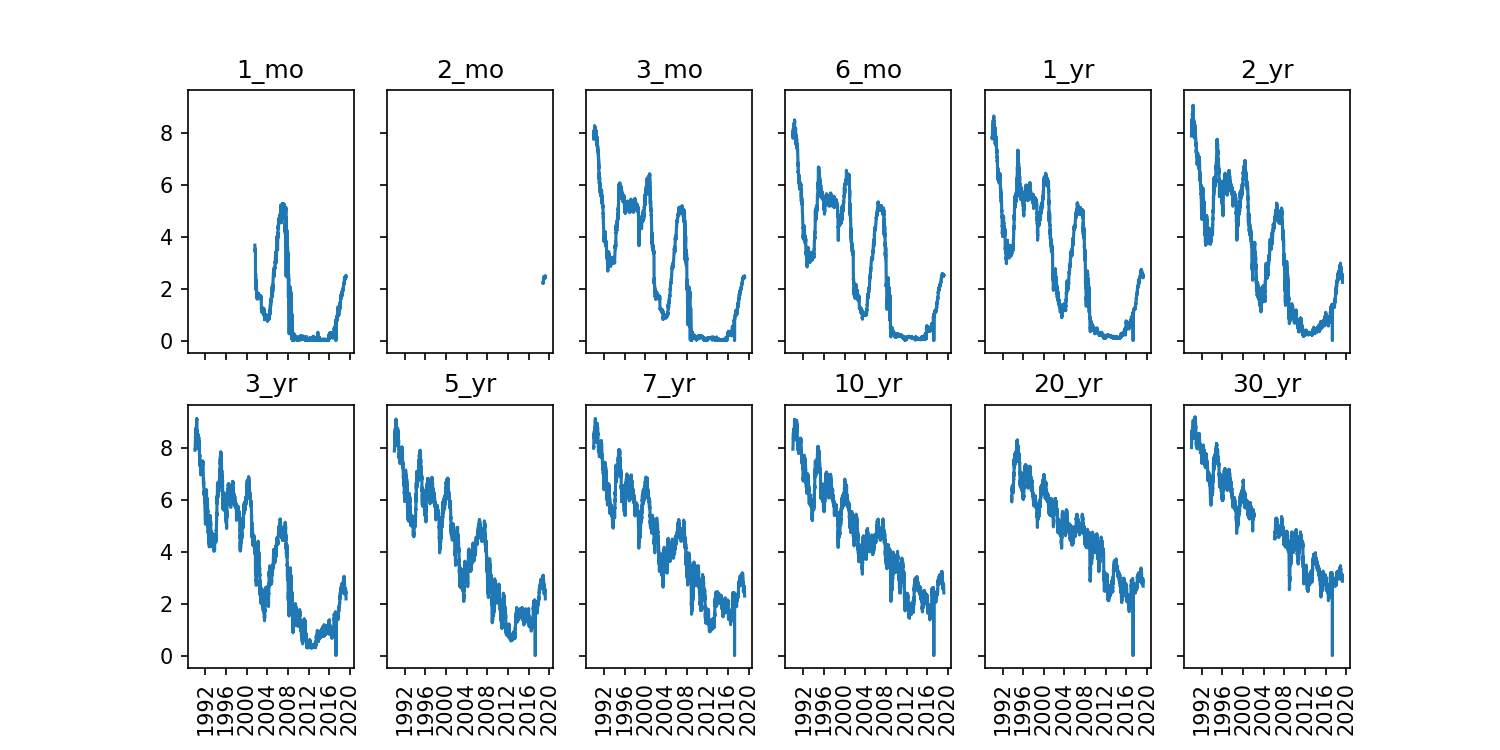

In [23]:
# Plotting it out
fig, ((ax1,ax2,ax3,ax4,ax5,ax6), (ax7,ax8,ax9,ax10,ax11,ax12)) = plt.subplots(2,6, sharex=True, sharey=True, 
                                                                              figsize=(10,5))
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
plot_columns = list(yield_curve_df.columns)
for n in range(0, len(axs)):
    axs[n].plot(yield_curve_df[plot_columns[n]])
    axs[n].set_title(plot_columns[n])
    x = axs[n].xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)

In [24]:
# Creating new df with spread colums
spread_df = yield_curve_df.copy()
spread_df['30y_vs_1m'] = spread_df['30_yr'] - spread_df['1_mo']
spread_df['20y_vs_2m'] = spread_df['20_yr'] - spread_df['2_mo']
spread_df['10y_vs_3m'] = spread_df['10_yr'] - spread_df['3_mo']
spread_df['7y_vs_6m'] = spread_df['7_yr'] - spread_df['6_mo']
spread_df['5y_vs_1y'] = spread_df['5_yr'] - spread_df['1_yr']
spread_df['3y_vs_2y'] = spread_df['3_yr'] - spread_df['2_yr']

<IPython.core.display.Javascript object>


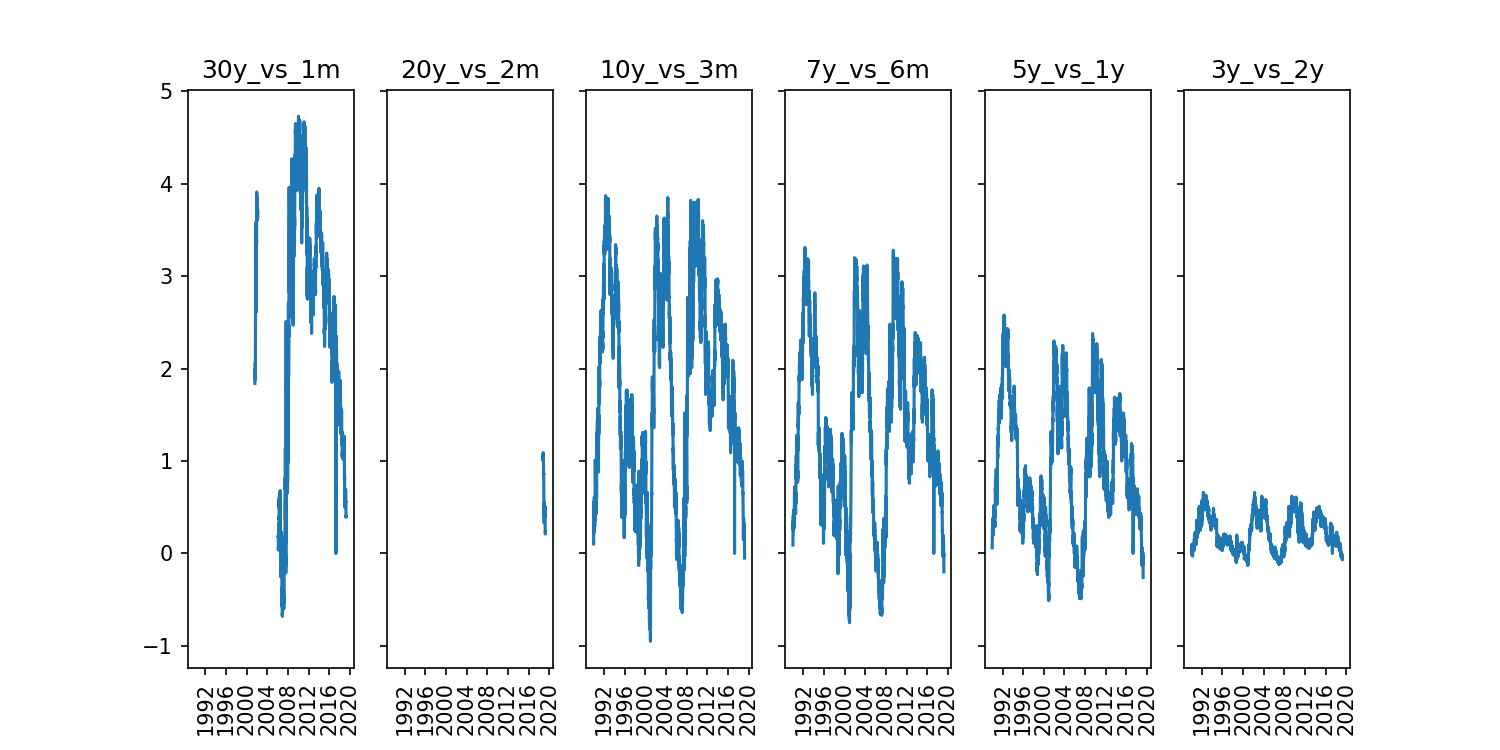

In [25]:
# Plotting the spreads

spread_fig, ((sax1,sax2,sax3,sax4,sax5,sax6)) = plt.subplots(1,6, sharex=True, sharey=True, figsize=(10,5))

spread_columns = ['30y_vs_1m', '20y_vs_2m', '10y_vs_3m', '7y_vs_6m', '5y_vs_1y', '3y_vs_2y']
spread_axs = [sax1,sax2,sax3,sax4,sax5,sax6]
for n in range(0, len(spread_axs)):
    spread_axs[n].plot(spread_df[spread_columns[n]])
    spread_axs[n].set_title(spread_columns[n])
    x = spread_axs[n].xaxis
    for item in x.get_ticklabels():
        item.set_rotation(90)

In [26]:
# Is there a clear pattern between reecssions and the 10 year vs 3 month spread?
recession_df = pd.read_csv('Downloads/JHDUSRGDPBR.csv')
recession_df.head()

,DATE,JHDUSRGDPBR
0,1967-10-01,0.0
1,1968-01-01,0.0
2,1968-04-01,0.0
3,1968-07-01,0.0
4,1968-10-01,0.0


In [27]:
# The recession data is quarterly, and I need it to be daily
recession_df['DATE'] = pd.to_datetime(recession_df['DATE'])
recession_df = recession_df.rename(columns={'JHDUSRGDPBR': 'recession'})
recession_df = recession_df.set_index('DATE')
timeframe = pd.date_range(recession_df.index.min(), yield_curve_df.index.max())
recession_df = recession_df.reindex(timeframe)
recession_df.head()

,recession
1967-10-01,0.0
1967-10-02,NaN
1967-10-03,NaN
1967-10-04,NaN
1967-10-05,NaN


In [29]:
# Need to fill the empty values with the last known value
recession_df = recession_df.fillna(method='ffill')

In [31]:
# Joining this recession data to my dataset
merged_df = pd.merge(spread_df, recession_df, how='left', left_index=True, right_index=True)
merged_df.head()

,1_mo,2_mo,3_mo,6_mo,1_yr,2_yr,3_yr,5_yr,7_yr,10_yr,20_yr,30_yr,30y_vs_1m,20y_vs_2m,10y_vs_3m,7y_vs_6m,5y_vs_1y,3y_vs_2y,recession
Date,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00,NaN,NaN,0.11,0.09,0.06,0.03,1.0
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04,NaN,NaN,0.10,0.10,0.07,0.02,1.0
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04,NaN,NaN,0.14,0.12,0.09,0.01,1.0
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06,NaN,NaN,0.20,0.18,0.13,0.04,1.0
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09,NaN,NaN,0.23,0.17,0.11,0.05,1.0


<IPython.core.display.Javascript object>


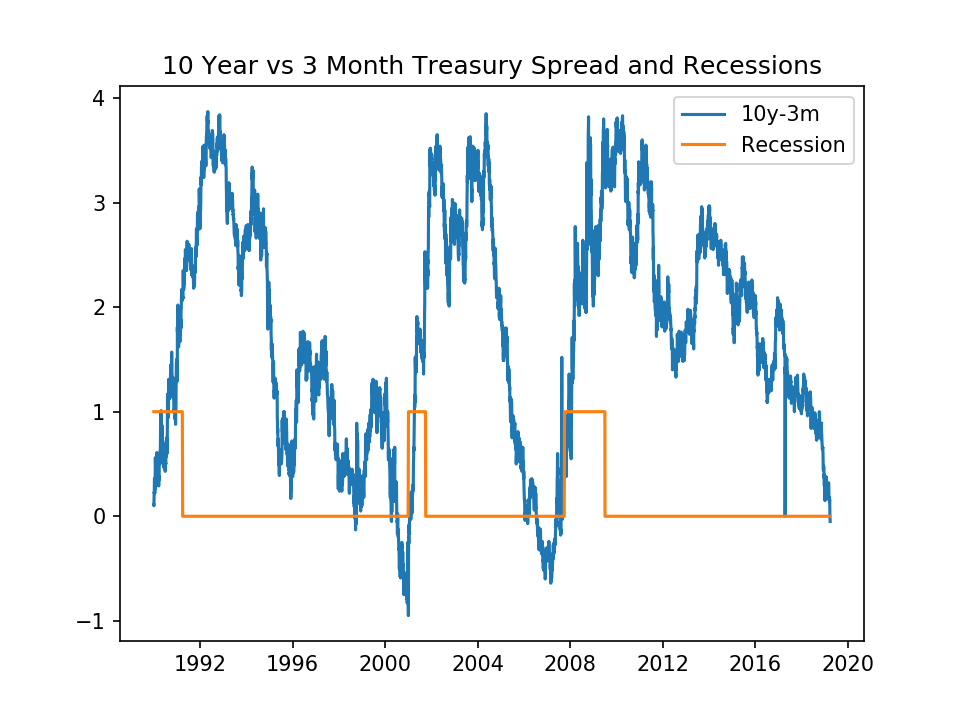

In [32]:
# Plotting
s = merged_df[['10y_vs_3m', 'recession']]
rec_fig, rec_ax = plt.subplots()
rec_ax.plot(s)
rec_ax.set_title('10 Year vs 3 Month Treasury Spread and Recessions')
rec_ax.legend(('10y-3m','Recession'))